In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import healpy as hp
from scipy.spatial import ConvexHull

import lsst.daf.butler as dafButler
from lsst.analysis.ap import apdb
from lsst.ap.association import AssociationTask, AssociationConfig
from lsst.dax.apdb import Apdb, ApdbCassandra, ApdbTables
import lsst.geom
from lsst.afw import image as afwImage

from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import ZScaleInterval, SqrtStretch, ImageNormalize, ManualInterval, AsinhStretch, MinMaxInterval, LogStretch


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from typing import TYPE_CHECKING, cast

import astropy.units as u
from astropy.coordinates import SkyCoord

plt.set_loglevel('WARNING')

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


# Custom functions

In [2]:
def create_mag_errors(sciFlux, sciFluxErr):
    """Move flux into magnitudes and calculate the error on the magnitude
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux
    sciFluxErr : `float`
        Science flux error

    Returns
    -------
    mag, magerr  : `float`, `float`
        Magnitude and magnitude error
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    upper_mag = u.nJy.to(u.ABmag, sciFlux+sciFluxErr)
    lower_mag = u.nJy.to(u.ABmag, sciFlux-sciFluxErr)
    magErr = -(upper_mag-lower_mag)/2
    
    return mag, magErr

def create_mag(sciFlux):
    """Move flux into magnitudes
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux

    Returns
    -------
    mag  : `float`
        Magnitude
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    
    return mag

def degrees_to_radians(degrees):
    """
    Convert an angle from degrees to radians.

    Parameters:
    degrees (float): Angle in degrees.

    Returns:
    float: Angle in radians (unitless).
    """
    # Convert the input degrees to radians
    radians = (degrees * u.deg).to(u.rad)
    
    # Return the numerical value (without the unit)
    return radians.value

def radians_to_degrees(radians):
    """
    Convert an angle from radians to degrees.

    Parameters:
    radians (float): Angle in radians.

    Returns:
    float: Angle in degrees (unitless).
    """
    # Convert the input radians to degrees
    degrees = (radians * u.rad).to(u.deg)
    
    # Return the numerical value (without the unit)
    return degrees.value

def flux_to_magnitude(df_single_flux_src):
    """Magic function that converts flux to magnitude; to be used in OR4

    Args:
        df_single_flux_src (_type_): _description_

    Returns:
        _type_: _description_
    """
    
    # Define the zeropoints for each band
    zeropoints = {
        'u': 12.652350670009373,
        'g': 14.689449213373276,
        'r': 14.559501946792281,
        'i': 14.378976834902065,
        'z': 13.993052964496345,
        'y': 13.017367314857484
    }
    
    # Create an empty dictionary to hold magnitudes
    mag_dict = {}
    
    # Apply the transformation for each band
    for band in zeropoints.keys():
        # Make sure the flux column for the band exists in the dataframe
        if f'lsst_flux_{band}' in df_single_flux_src.columns:
            flux_col = f'lsst_flux_{band}'
            mag_col = f'mag_{band}'
            
            # Calculate magnitudes from flux: mag = zp - 2.5 * log10(flux)
            # Handling zero or negative flux values to avoid invalid log10 operations
            mag_dict[mag_col] = zeropoints[band] - 2.5 * np.log10(df_single_flux_src[flux_col].replace(0, np.nan))
    
    # Convert the dictionary to a DataFrame and concatenate with the original dataframe
    mag_df = pd.DataFrame(mag_dict)
    
    # Return the original dataframe with new magnitude columns
    return pd.concat([df_single_flux_src, mag_df], axis=1)


In [3]:
# at the moment comcam only in Cassandra
# from lsst.analysis.ap import apdbCassandra
# or4_apdb_Cassandra = apdbCassandra.DbCassandraQuery(config_uri='s3://embargo@rubin-summit-users/apdb_config/cassandra/pp_apdb_lsstcomcamsim_or4.py')
# comcam_apdb_Cassandra = apdbCassandra.DbCassandraQuery(config_uri='s3://embargo@rubin-summit-users/apdb_config/cassandra/pp_apdb_lsstcomcam.py')

# Import data

In [4]:
# Load collection
repo = "embargo_new"
collection = "LSSTComCam/runs/DRP/20241101_20241211/w_2024_50/DM-48128"
instrument = "LSSTComCam"

butler = dafButler.Butler(repo, collections=collection, instrument=instrument)
# older collections
butler_49 = dafButler.Butler(repo, collections="LSSTComCam/runs/DRP/20241101_20241204/w_2024_49/DM-47988", instrument=instrument)
butler_48 = dafButler.Butler(repo, collections="LSSTComCam/runs/DRP/20241101_20241127/w_2024_48/DM-47841", instrument=instrument)



INFO:botocore.credentials:Found credentials in shared credentials file: /sdf/home/n/ncaplar/.lsst/aws-credentials.ini


In [ ]:
bands = ["u", "g", "r", "i", "z", "y"]
verbose = False

for band in bands:
    datasetRefs_dia = butler.query_datasets("goodSeeingDiff_differenceExp", where=f"band='{band}'")

    if verbose:
        print(f"\nDataset references for band '{band}':")
        for dr in datasetRefs_dia:
            print(dr)

    print(f"Found {len(datasetRefs_dia)} differenceExps for band '{band}'")

Found 1024 differenceExps for band 'u'
Found 4181 differenceExps for band 'g'
Found 5821 differenceExps for band 'r'
Found 2877 differenceExps for band 'i'
Found 2719 differenceExps for band 'z'
Found 583 differenceExps for band 'y'


In [6]:
# just one data_id for potential testing
i = 50
data_id = datasetRefs_dia[i].dataId
print(data_id)

{instrument: 'LSSTComCam', detector: 0, visit: 2024112000314, band: 'y', day_obs: 20241120, physical_filter: 'y_04'}


In [71]:
lc_refs = butler.query_datasets("diaSourceTable_tract")
obj_refs = butler.query_datasets("diaObjectTable_tract")
obj_refs_49 = butler_49.query_datasets("diaObjectTable_tract")
obj_refs_48 = butler_48.query_datasets("diaObjectTable_tract")

print(len(lc_refs))
print(f"Number of tracts in obj_refs (current): {len(obj_refs)}")
print(f"Number of tracts in obj_refs_49 (weekly 49): {len(obj_refs_49)}")
print(f"Number of tracts in obj_refs_48 (weekly 48): {len(obj_refs_48)}")

40
Number of tracts in obj_refs (current): 40
Number of tracts in obj_refs_49 (weekly 49): 45
Number of tracts in obj_refs_48 (weekly 48): 43


Text(0.5, 1.0, 'Log Number of diaObjects per Number of Sources per Object')

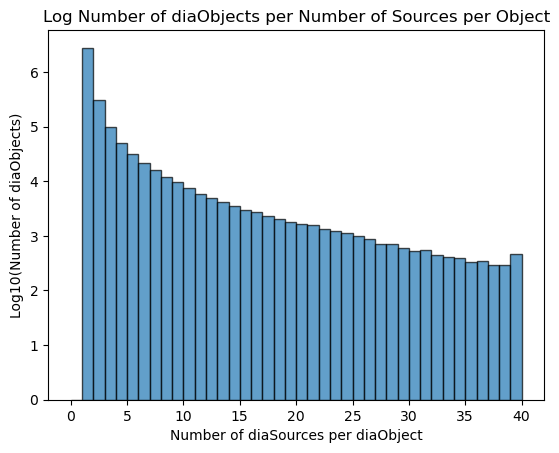

In [8]:
# List of tract indices to process
tract_indices = np.arange(0, len(obj_refs))

# Initialize lists to hold diaObj and diaSource DataFrames
dia_Obj_list = []
diaSource_list = []

# Loop through the specified tracts and fetch the data
for idx in tract_indices:
    obj_ref = obj_refs[idx]  # Select the corresponding obj_ref
    dia_Obj = butler.get(obj_ref)  # Fetch diaObj for this tract
    diaSource = butler.get('diaSourceTable_tract', dataId=obj_ref.dataId)  # Fetch diaSource for this tract
    
    # Append the results to the lists
    dia_Obj_list.append(dia_Obj)
    diaSource_list.append(diaSource)

# Concatenate all diaObj and diaSource DataFrames
combined_dia_Obj = pd.concat(dia_Obj_list, ignore_index=False)
combined_diaSource = pd.concat(diaSource_list, ignore_index=False)

dia_Obj = combined_dia_Obj.copy()
diaSource = combined_diaSource.copy()

dia_Obj_50 = combined_dia_Obj.copy()
diaSource_50 = combined_diaSource.copy()

# Compute the histogram of nDiaSources
counts, bin_edges = np.histogram(combined_dia_Obj['nDiaSources'], bins=40, range=(0, 40))

# Take the logarithm (base 10) of the counts
log_counts = np.log10(counts + 1)  # Add 1 to avoid log(0)

# Plot the histogram
plt.bar(bin_edges[:-1], log_counts, width=np.diff(bin_edges), align='edge', edgecolor='black', alpha=0.7)
plt.xlabel('Number of diaSources per diaObject')
plt.ylabel('Log10(Number of diaObjects)')
plt.title('Log Number of diaObjects per Number of Sources per Object')

In [9]:
# Step 1: Calculate mean flux and mean SNR for each diaObjectId in each band
mean_flux_per_object_band = diaSource.groupby(['diaObjectId', 'band'])['scienceFlux'].mean().unstack(fill_value=0)
mean_snr_per_object_band = diaSource.groupby(['diaObjectId', 'band'])['snr'].mean().unstack(fill_value=-99)

# Rename columns dynamically for all bands
band_flux_columns = {band: f"{band}_band_flux_mean" for band in ['i', 'g', 'r', 'y', 'z', 'u']}
band_snr_columns = {band: f"{band}_band_snr_mean" for band in ['i', 'g', 'r', 'y', 'z', 'u']}
mean_flux_per_object_band = mean_flux_per_object_band.rename(columns=band_flux_columns).reset_index()
mean_snr_per_object_band = mean_snr_per_object_band.rename(columns=band_snr_columns).reset_index()

# Step 2: Merge mean flux and SNR values into dia_Obj_field
dia_Obj_field_updated = dia_Obj.merge(mean_flux_per_object_band, on='diaObjectId', how='left')
dia_Obj_field_updated = dia_Obj_field_updated.merge(mean_snr_per_object_band, on='diaObjectId', how='left')

# Step 3: Calculate magnitudes for all bands (vectorized)
for band in tqdm(['i', 'g', 'r', 'y', 'z', 'u']):
    flux_col = f"{band}_band_flux_mean"
    mag_col = f"{band}_band_mag"
    
    # Assuming create_mag is a function that works element-wise
    dia_Obj_field_updated[mag_col] = create_mag(dia_Obj_field_updated[flux_col].values)

# Replace infinite values with NaN
dia_Obj_field_updated.replace([np.inf, -99, -np.inf], np.nan, inplace=True)

# Select and display the magnitude columns, SNR, and diaObjectId
output_columns = ['diaObjectId'] + \
                 [f"{band}_band_mag" for band in ['i', 'g', 'r', 'y', 'z', 'u']] + \
                 [f"{band}_band_snr_mean" for band in ['i', 'g', 'r', 'y', 'z', 'u']]

result_50 = dia_Obj_field_updated[output_columns]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.35it/s]


In [10]:
result_50

,diaObjectId,i_band_mag,g_band_mag,r_band_mag,y_band_mag,z_band_mag,u_band_mag,i_band_snr_mean,g_band_snr_mean,r_band_snr_mean,y_band_snr_mean,z_band_snr_mean,u_band_snr_mean
0,2132903024304062465,NaN,NaN,NaN,NaN,18.522501,NaN,NaN,NaN,NaN,NaN,27.982355,NaN
1,2132907422350573569,NaN,NaN,19.175584,NaN,NaN,NaN,NaN,NaN,13.886337,NaN,NaN,NaN
2,2132907422350573570,NaN,NaN,19.796725,NaN,NaN,NaN,NaN,NaN,9.233916,NaN,NaN,NaN
3,2132907422350573571,17.913396,20.378766,19.051455,NaN,17.413758,NaN,58.117743,11.148803,21.264280,NaN,51.141682,NaN
4,2132907422350573572,16.450193,18.880931,17.470898,NaN,NaN,NaN,114.113010,26.237786,21.189686,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3375630,2717130726746095751,NaN,NaN,21.664858,NaN,NaN,NaN,NaN,NaN,5.719101,NaN,NaN,NaN
3375631,2717130726746095752,NaN,NaN,16.537516,NaN,NaN,NaN,NaN,NaN,36.753014,NaN,NaN,NaN
3375632,2717135124792606721,NaN,NaN,19.103217,NaN,NaN,NaN,NaN,NaN,8.207921,NaN,NaN,NaN
3375633,2717135124792606722,NaN,NaN,20.282225,NaN,NaN,NaN,NaN,NaN,7.071384,NaN,NaN,NaN


Text(0.5, 1.0, 'Log Number of diaObjects per Number of Sources per Object')

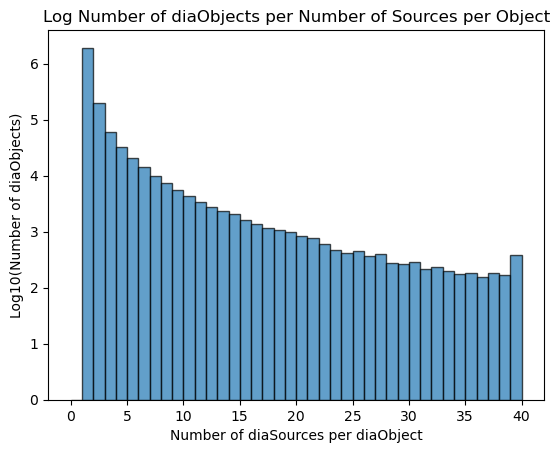

In [11]:
# List of tract indices to process
tract_indices = np.arange(0, len(obj_refs_49))

# Initialize lists to hold diaObj and diaSource DataFrames
dia_Obj_list = []
diaSource_list = []

# Loop through the specified tracts and fetch the data
for idx in tract_indices:
    obj_ref = obj_refs_49[idx]  # Select the corresponding obj_ref
    dia_Obj = butler_49.get(obj_ref)  # Fetch diaObj for this tract
    diaSource = butler_49.get('diaSourceTable_tract', dataId=obj_ref.dataId)  # Fetch diaSource for this tract
    
    # Append the results to the lists
    dia_Obj_list.append(dia_Obj)
    diaSource_list.append(diaSource)

# Concatenate all diaObj and diaSource DataFrames
combined_dia_Obj = pd.concat(dia_Obj_list, ignore_index=False)
combined_diaSource = pd.concat(diaSource_list, ignore_index=False)

dia_Obj_49 = combined_dia_Obj.copy()
diaSource_49 = combined_diaSource.copy()

# Compute the histogram of nDiaSources
counts, bin_edges = np.histogram(combined_dia_Obj['nDiaSources'], bins=40, range=(0, 40))

# Take the logarithm (base 10) of the counts
log_counts = np.log10(counts + 1)  # Add 1 to avoid log(0)

# Plot the histogram
plt.bar(bin_edges[:-1], log_counts, width=np.diff(bin_edges), align='edge', edgecolor='black', alpha=0.7)
plt.xlabel('Number of diaSources per diaObject')
plt.ylabel('Log10(Number of diaObjects)')
plt.title('Log Number of diaObjects per Number of Sources per Object')

Text(0.5, 1.0, 'Log Number of diaObjects per Number of Sources per Object')

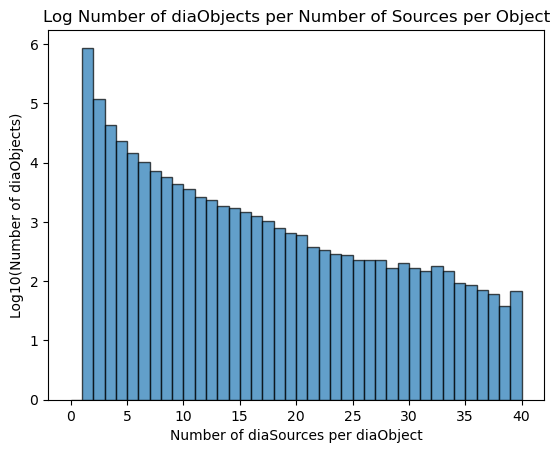

In [12]:
# List of tract indices to process
tract_indices = np.arange(0, len(obj_refs_48))

# Initialize lists to hold diaObj and diaSource DataFrames
dia_Obj_list = []
diaSource_list = []

# Loop through the specified tracts and fetch the data
for idx in tract_indices:
    obj_ref = obj_refs_48[idx]  # Select the corresponding obj_ref
    dia_Obj = butler_48.get(obj_ref)  # Fetch diaObj for this tract
    diaSource = butler_48.get('diaSourceTable_tract', dataId=obj_ref.dataId)  # Fetch diaSource for this tract
    
    # Append the results to the lists
    dia_Obj_list.append(dia_Obj)
    diaSource_list.append(diaSource)

# Concatenate all diaObj and diaSource DataFrames
combined_dia_Obj = pd.concat(dia_Obj_list, ignore_index=False)
combined_diaSource = pd.concat(diaSource_list, ignore_index=False)

dia_Obj_48 = combined_dia_Obj.copy()
diaSource_48 = combined_diaSource.copy()

# Compute the histogram of nDiaSources
counts, bin_edges = np.histogram(combined_dia_Obj['nDiaSources'], bins=40, range=(0, 40))

# Take the logarithm (base 10) of the counts
log_counts = np.log10(counts + 1)  # Add 1 to avoid log(0)

# Plot the histogram
plt.bar(bin_edges[:-1], log_counts, width=np.diff(bin_edges), align='edge', edgecolor='black', alpha=0.7)
plt.xlabel('Number of diaSources per diaObject')
plt.ylabel('Log10(Number of diaObjects)')
plt.title('Log Number of diaObjects per Number of Sources per Object')

In [13]:
# Step 1: Calculate mean flux and mean SNR for each diaObjectId in each band
mean_flux_per_object_band = diaSource_48.groupby(['diaObjectId', 'band'])['scienceFlux'].mean().unstack(fill_value=0)
mean_snr_per_object_band = diaSource_48.groupby(['diaObjectId', 'band'])['snr'].mean().unstack(fill_value=-99)

# Rename columns dynamically for all bands
band_flux_columns = {band: f"{band}_band_flux_mean" for band in ['i', 'g', 'r', 'y', 'z', 'u']}
band_snr_columns = {band: f"{band}_band_snr_mean" for band in ['i', 'g', 'r', 'y', 'z', 'u']}
mean_flux_per_object_band = mean_flux_per_object_band.rename(columns=band_flux_columns).reset_index()
mean_snr_per_object_band = mean_snr_per_object_band.rename(columns=band_snr_columns).reset_index()

# Step 2: Merge mean flux and SNR values into dia_Obj_field
dia_Obj_field_updated = dia_Obj_48.merge(mean_flux_per_object_band, on='diaObjectId', how='left')
dia_Obj_field_updated = dia_Obj_field_updated.merge(mean_snr_per_object_band, on='diaObjectId', how='left')

# Step 3: Calculate magnitudes for all bands (vectorized)
for band in tqdm(['i', 'g', 'r', 'y', 'z', 'u']):
    flux_col = f"{band}_band_flux_mean"
    mag_col = f"{band}_band_mag"
    
    # Assuming create_mag is a function that works element-wise
    dia_Obj_field_updated[mag_col] = create_mag(dia_Obj_field_updated[flux_col].values)

# Replace infinite values with NaN
dia_Obj_field_updated.replace([np.inf, -99, -np.inf], np.nan, inplace=True)

# Select and display the magnitude columns, SNR, and diaObjectId
output_columns = ['diaObjectId'] + \
                 [f"{band}_band_mag" for band in ['i', 'g', 'r', 'y', 'z', 'u']] + \
                 [f"{band}_band_snr_mean" for band in ['i', 'g', 'r', 'y', 'z', 'u']]

result_48 = dia_Obj_field_updated[output_columns]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 75.51it/s]


In [14]:
result_48

,diaObjectId,i_band_mag,g_band_mag,r_band_mag,y_band_mag,z_band_mag,u_band_mag,i_band_snr_mean,g_band_snr_mean,r_band_snr_mean,y_band_snr_mean,z_band_snr_mean,u_band_snr_mean
0,983398801836343297,24.369768,NaN,NaN,NaN,NaN,NaN,5.325526,NaN,NaN,NaN,NaN,NaN
1,983398801836343298,19.945555,NaN,NaN,NaN,NaN,NaN,15.802820,NaN,NaN,NaN,NaN,NaN
2,983398801836343299,18.555489,NaN,NaN,NaN,NaN,NaN,6.246613,NaN,NaN,NaN,NaN,NaN
3,983398801836343300,21.625804,NaN,NaN,NaN,NaN,NaN,8.079609,NaN,NaN,NaN,NaN,NaN
4,983398801836343301,19.830976,NaN,NaN,NaN,NaN,NaN,6.906067,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117270,1766668895231410233,NaN,NaN,17.949047,NaN,NaN,NaN,NaN,NaN,11.118386,NaN,NaN,NaN
1117271,1766668895231410234,NaN,NaN,18.592064,NaN,NaN,NaN,NaN,NaN,5.006464,NaN,NaN,NaN
1117272,1766668895231410235,NaN,NaN,23.149542,NaN,NaN,NaN,NaN,NaN,5.119714,NaN,NaN,NaN
1117273,1766668895231410236,NaN,NaN,19.183325,NaN,NaN,NaN,NaN,NaN,7.049816,NaN,NaN,NaN


# Number of diaObjects per magnitude

In [15]:
output_string = (
    f"DRP50: Number of unique visits: {len(np.unique(diaSource_50['visit']))}, "
    f"Number of unique diaObjectId: {len(np.unique(diaSource_50['diaObjectId']))}, "
    f"Total number of diaSource entries: {len(diaSource_50)}"
)

output_string_49 = (
    f"DRP49: Number of unique visits: {len(np.unique(diaSource_49['visit']))}, "
    f"Number of unique diaObjectId: {len(np.unique(diaSource_49['diaObjectId']))}, "
    f"Total number of diaSource entries: {len(diaSource_49)}"
)

output_string_48 = (
    f"DRP48: Number of unique visits: {len(np.unique(diaSource_48['visit']))}, "
    f"Number of unique diaObjectId: {len(np.unique(diaSource_48['diaObjectId']))}, "
    f"Total number of diaSource entries: {len(diaSource_48)}"
)


print(output_string)
print(output_string_49)
print(output_string_48)

DRP50: Number of unique visits: 1943, Number of unique diaObjectId: 3375635, Total number of diaSource entries: 6191182
DRP49: Number of unique visits: 1256, Number of unique diaObjectId: 2314013, Total number of diaSource entries: 3856270
DRP48: Number of unique visits: 772, Number of unique diaObjectId: 1117275, Total number of diaSource entries: 2020723


In [74]:
visits_48_uniq = np.unique(diaSource_48['visit'])
diaSource_50_48 = diaSource_50[diaSource_50['visit'].isin(visits_48_uniq)]
print('Number of diaSources with weekly 50, on data collected until w48: '+str(len(diaSource_50_48)))
print('Number of visits with weekly 50, on data collected until w48: '+str(len(np.unique(diaSource_50_48['visit']))))

Number of diaSources with weekly 50, on data collected until w48: 1876345
Number of visits with weekly 50, on data collected until w48: 765


In [17]:
"""
dia = butler.get("goodSeeingDiff_differenceExp", dataId=data_id)
template = butler.get("goodSeeingDiff_templateExp", dataId=data_id)
calexp = butler.get("calexp", dataId=data_id)
src = butler.get("src", dataId=data_id)
dia_src = butler.get("goodSeeingDiff_diaSrc", dataId=data_id)
dia_src_table = butler.get("goodSeeingDiff_diaSrcTable", dataId=data_id) 
"""

'\ndia = butler.get("goodSeeingDiff_differenceExp", dataId=data_id)\ntemplate = butler.get("goodSeeingDiff_templateExp", dataId=data_id)\ncalexp = butler.get("calexp", dataId=data_id)\nsrc = butler.get("src", dataId=data_id)\ndia_src = butler.get("goodSeeingDiff_diaSrc", dataId=data_id)\ndia_src_table = butler.get("goodSeeingDiff_diaSrcTable", dataId=data_id) \n'

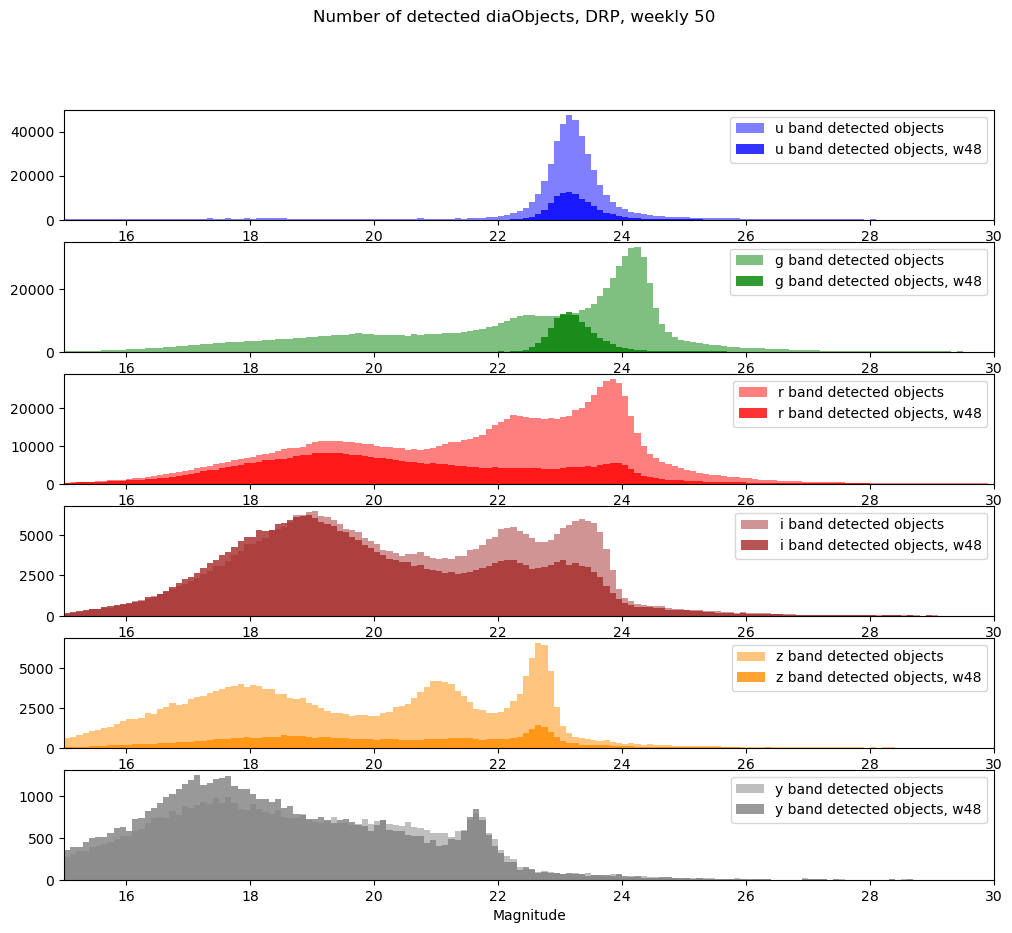

In [18]:
result = result_50.copy()

plt.figure(figsize=(12, 10))
plt.suptitle('Number of detected diaObjects, DRP, weekly 50')

plt.subplot(6, 1, 1)
plt.hist(result['u_band_mag'][~np.isnan(result['u_band_mag'])], color='blue', alpha=0.5, bins=np.arange(15,30,0.1), label='u band detected objects');
plt.hist(result_48['u_band_mag'][~np.isnan(result_48['u_band_mag'])], color='blue', alpha=0.8, bins=np.arange(15,30,0.1), label='u band detected objects, w48');
plt.xlim(15, 30)
plt.xlabel('Magnitude')
plt.legend();

plt.subplot(6, 1, 2)
plt.hist(result['g_band_mag'][~np.isnan(result['g_band_mag'])], color='g', alpha=0.5, bins=np.arange(15,30,0.1), label='g band detected objects');
plt.hist(result_48['u_band_mag'][~np.isnan(result_48['u_band_mag'])], color='g', alpha=0.8, bins=np.arange(15,30,0.1), label='g band detected objects, w48');
plt.xlim(15, 30)
plt.xlabel('Magnitude')
plt.legend();

plt.subplot(6, 1, 3)
plt.hist(result['r_band_mag'][~np.isnan(result['r_band_mag'])], color='r', alpha=0.5, bins=np.arange(15,30,0.1), label='r band detected objects');
plt.hist(result_48['r_band_mag'][~np.isnan(result_48['r_band_mag'])], color='r', alpha=0.8, bins=np.arange(15,30,0.1), label='r band detected objects, w48');
plt.xlim(15, 30)
plt.xlabel('Magnitude')
plt.legend();

plt.subplot(6, 1,4)
plt.hist(result['i_band_mag'][~np.isnan(result['i_band_mag'])], color='brown', alpha=0.5, bins=np.arange(15,30,0.1), label='i band detected objects');
plt.hist(result_48['i_band_mag'][~np.isnan(result_48['i_band_mag'])], color='brown', alpha=0.8, bins=np.arange(15,30,0.1), label='i band detected objects, w48');
plt.xlim(15, 30)
plt.xlabel('Magnitude')
plt.legend();

plt.subplot(6, 1,5)
plt.hist(result['z_band_mag'][~np.isnan(result['z_band_mag'])], color='darkorange', alpha=0.5, bins=np.arange(15,30,0.1), label='z band detected objects');
plt.hist(result_48['z_band_mag'][~np.isnan(result_48['z_band_mag'])], color='darkorange', alpha=0.8, bins=np.arange(15,30,0.1), label='z band detected objects, w48');
plt.xlim(15, 30)
plt.xlabel('Magnitude')
plt.legend();

plt.subplot(6, 1,6)
plt.hist(result['y_band_mag'][~np.isnan(result['y_band_mag'])], color='gray', alpha=0.5, bins=np.arange(15,30,0.1), label='y band detected objects');
plt.hist(result_48['y_band_mag'][~np.isnan(result_48['y_band_mag'])], color='gray', alpha=0.8, bins=np.arange(15,30,0.1), label='y band detected objects, w48');
plt.xlim(15, 30)
plt.xlabel('Magnitude')
plt.legend();

In [19]:
# SNR plot, not super interesting imo
"""
# Define colors for each band
band_colors = {
    'u': 'blue',
    'g': 'green',
    'r': 'red',
    'i': 'brown',
    'z': 'darkorange',
    'y': 'gray'
}

# Define the bands
bands = ['u', 'g', 'r', 'i', 'z', 'y']

# Create subplots with one figure per band
fig, axes = plt.subplots(len(bands), 1, figsize=(8, 18), sharex=True)
fig.suptitle('SNR Distribution Across Bands', fontsize=16)

for ax, band in zip(axes, bands):
    # Dynamically get the correct SNR column for the current band
    column_name = f'{band}_band_snr_mean'
    snr_values = result[column_name][~np.isnan(result[column_name])]
    
    # Plot the histogram for the current band
    ax.hist(
        snr_values, 
        color=band_colors[band], 
        alpha=0.7, 
        bins=np.arange(0, 30, 0.1), 
        label=f'{band} band detected objects'
    )
    ax.set_ylabel('Frequency')
    ax.set_title(f'{band} Band')
    ax.legend()

# Set common x-axis label
axes[-1].set_xlabel('SNR')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for the suptitle
plt.show()
"""

"\n# Define colors for each band\nband_colors = {\n    'u': 'blue',\n    'g': 'green',\n    'r': 'red',\n    'i': 'brown',\n    'z': 'darkorange',\n    'y': 'gray'\n}\n\n# Define the bands\nbands = ['u', 'g', 'r', 'i', 'z', 'y']\n\n# Create subplots with one figure per band\nfig, axes = plt.subplots(len(bands), 1, figsize=(8, 18), sharex=True)\nfig.suptitle('SNR Distribution Across Bands', fontsize=16)\n\nfor ax, band in zip(axes, bands):\n    # Dynamically get the correct SNR column for the current band\n    column_name = f'{band}_band_snr_mean'\n    snr_values = result[column_name][~np.isnan(result[column_name])]\n    \n    # Plot the histogram for the current band\n    ax.hist(\n        snr_values, \n        color=band_colors[band], \n        alpha=0.7, \n        bins=np.arange(0, 30, 0.1), \n        label=f'{band} band detected objects'\n    )\n    ax.set_ylabel('Frequency')\n    ax.set_title(f'{band} Band')\n    ax.legend()\n\n# Set common x-axis label\naxes[-1].set_xlabel('SNR')\

In [ ]:
# what are the columns that we can access 
diaSource.columns

Index(['visit', 'detector', 'band', 'diaObjectId', 'ssObjectId',
       'parentDiaSourceId', 'midpointMjdTai', 'bboxSize', 'time_processed',
       'ra', 'dec', 'raErr', 'decErr', 'ra_dec_Cov', 'x', 'y', 'xErr', 'yErr',
       'apFlux', 'apFluxErr', 'snr', 'psfFlux', 'psfFluxErr', 'psfChi2',
       'psfNdata', 'trailFlux', 'trailRa', 'trailDec', 'trailLength',
       'trailAngle', 'dipoleMeanFlux', 'dipoleMeanFluxErr', 'dipoleFluxDiff',
       'dipoleFluxDiffErr', 'dipoleLength', 'dipoleAngle', 'dipoleChi2',
       'isDipole', 'dipoleNdata', 'scienceFlux', 'scienceFluxErr', 'ixx',
       'iyy', 'ixy', 'ixxPSF', 'iyyPSF', 'ixyPSF', 'extendedness',
       'reliability', 'pixelFlags', 'pixelFlags_offimage', 'pixelFlags_edge',
       'pixelFlags_interpolated', 'pixelFlags_saturated', 'pixelFlags_cr',
       'pixelFlags_bad', 'pixelFlags_suspect', 'pixelFlags_interpolatedCenter',
       'pixelFlags_saturatedCenter', 'pixelFlags_crCenter',
       'pixelFlags_suspectCenter', 'centroid_flag', 

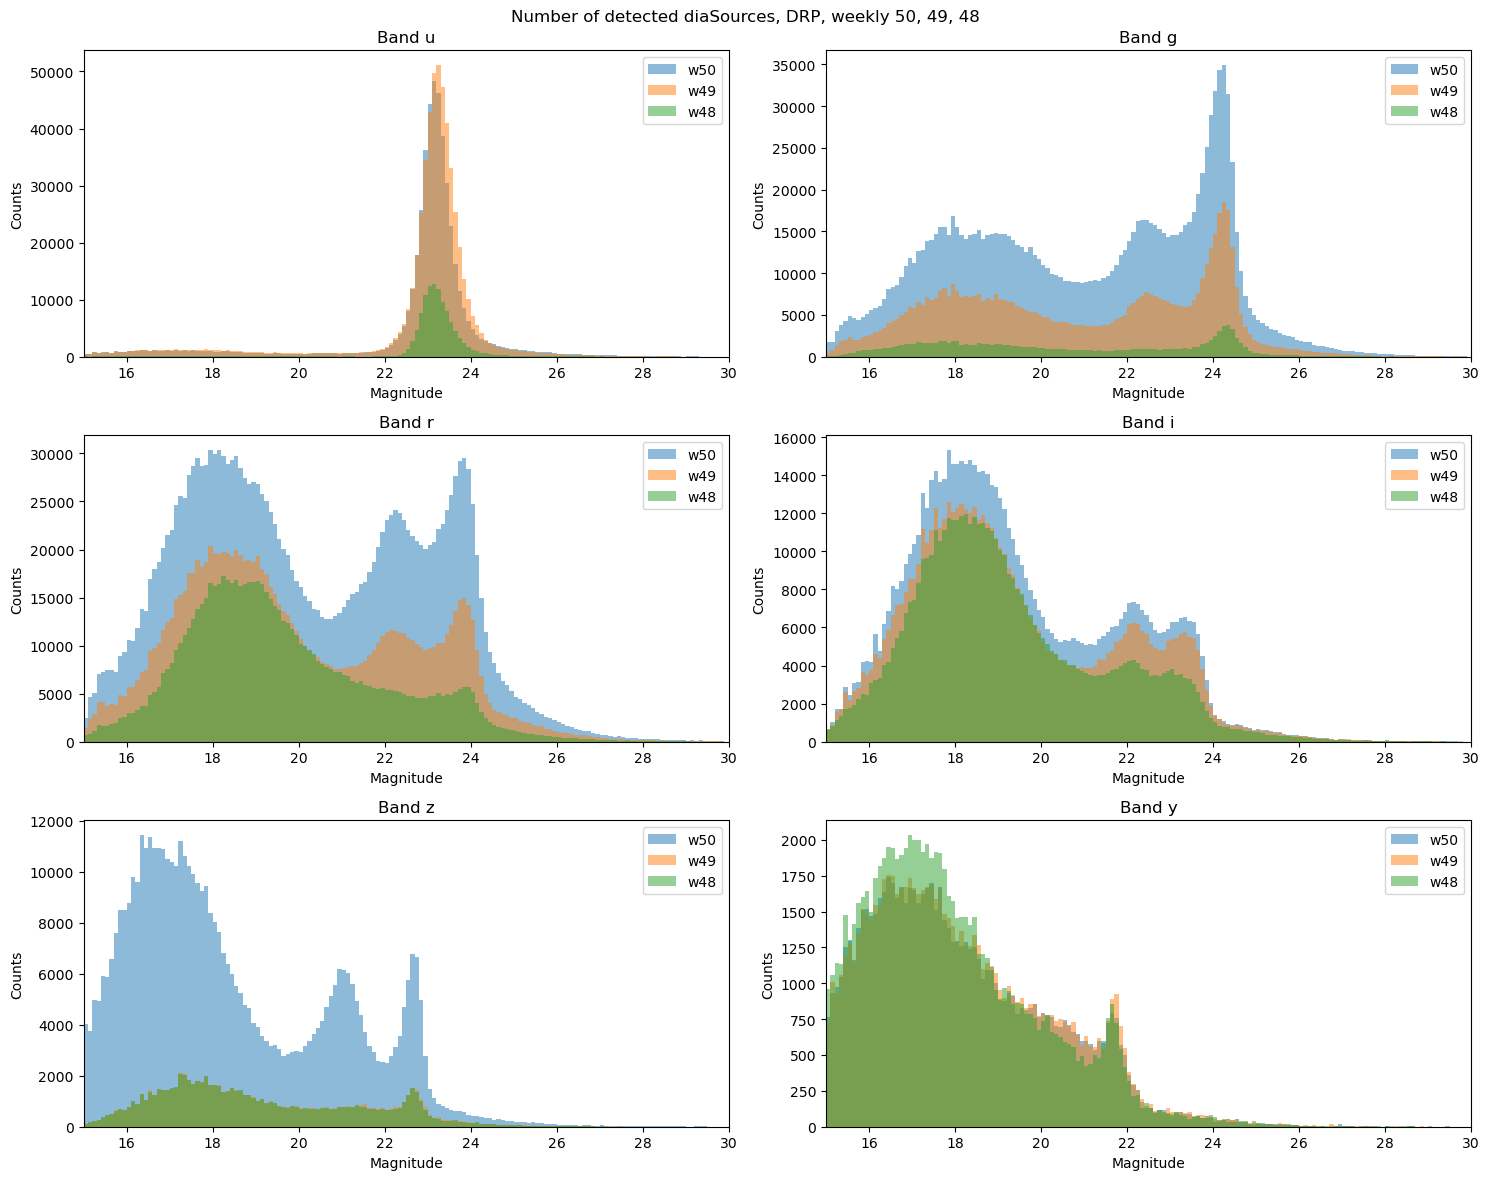

In [75]:
# Define the bands
bands = ['u', 'g', 'r', 'i', 'z', 'y']

# Create a figure with 6 subplots (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
plt.suptitle('Number of detected diaSources, DRP, weekly 50, 49, 48')
axes = axes.flatten()

# Loop over each band and create subplots
for idx, band in enumerate(bands):
    # Filter and process diaSource_50, diaSource_49, diaSource_48 for the current band
    dia_Source_single_band_50 = diaSource_50[diaSource_50['band'] == band].copy()
    dia_Source_single_band_50.loc[:, 'scienceMag'] = create_mag(dia_Source_single_band_50['scienceFlux'].values)
    
    dia_Source_single_band_49 = diaSource_49[diaSource_49['band'] == band].copy()
    dia_Source_single_band_49.loc[:, 'scienceMag'] = create_mag(dia_Source_single_band_49['scienceFlux'].values)
    
    dia_Source_single_band_48 = diaSource_48[diaSource_48['band'] == band].copy()
    dia_Source_single_band_48.loc[:, 'scienceMag'] = create_mag(dia_Source_single_band_48['scienceFlux'].values)
    
    # Plot histograms
    ax = axes[idx]
    ax.hist(dia_Source_single_band_50['scienceMag'], alpha=0.5, label='w50', bins=np.arange(15, 30, 0.1))
    ax.hist(dia_Source_single_band_49['scienceMag'], alpha=0.5, label='w49', bins=np.arange(15, 30, 0.1))
    ax.hist(dia_Source_single_band_48['scienceMag'], alpha=0.5, label='w48', bins=np.arange(15, 30, 0.1))
    
    # Formatting
    ax.set_xlim(15, 30)
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Counts')
    ax.set_title(f'Band {band}')
    ax.legend()

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

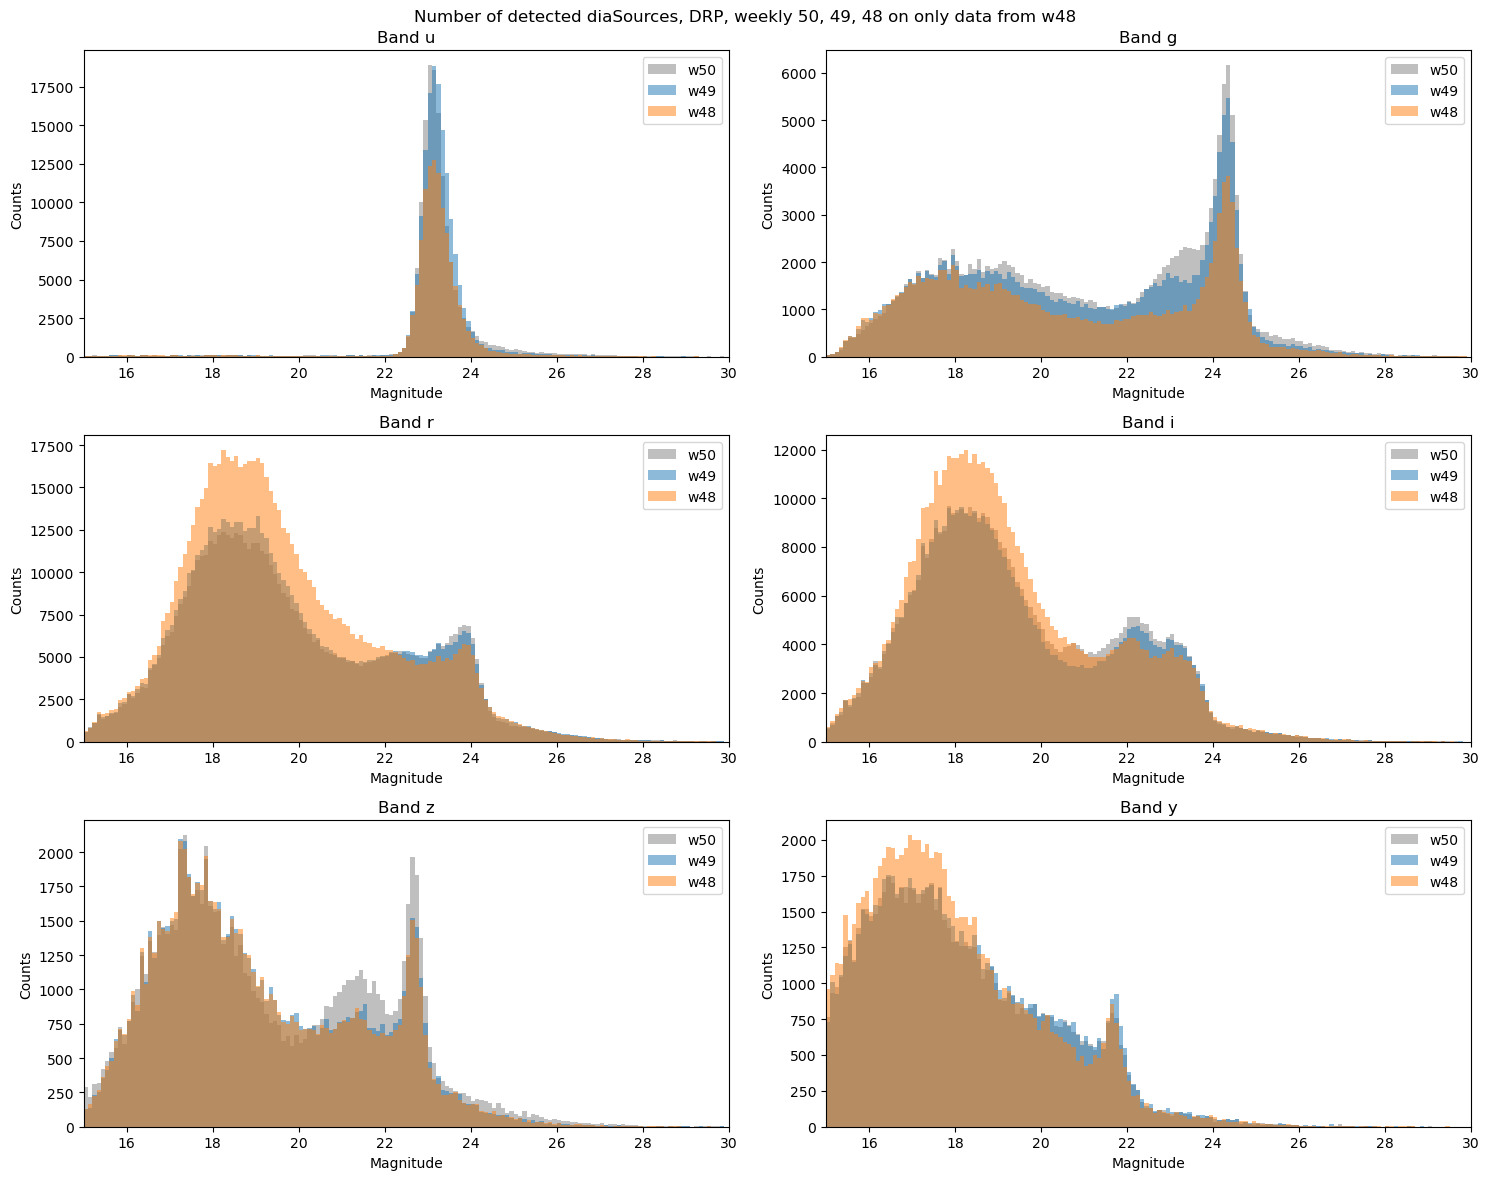

In [129]:
# same set of visits for all of them 
diaSource_50_48 = diaSource_50[diaSource_50['visit'].isin(visits_48_uniq)]
diaSource_49_48 = diaSource_49[diaSource_49['visit'].isin(visits_48_uniq)]
# Define the bands
bands = ['u', 'g', 'r', 'i', 'z', 'y']

# Create a figure with 6 subplots (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
plt.suptitle('Number of detected diaSources, DRP, weekly 50, 49, 48 on only data from w48')

axes = axes.flatten()

# Loop over each band and create subplots
for idx, band in enumerate(bands):
    # Filter and process diaSource_50, diaSource_49, diaSource_48 for the current band
    dia_Source_single_band_50 = diaSource_50_48[diaSource_50_48['band'] == band].copy()
    dia_Source_single_band_50.loc[:, 'scienceMag'] = create_mag(dia_Source_single_band_50['scienceFlux'].values)
    
    dia_Source_single_band_49 = diaSource_49_48[diaSource_49_48['band'] == band].copy()
    dia_Source_single_band_49.loc[:, 'scienceMag'] = create_mag(dia_Source_single_band_49['scienceFlux'].values)
    
    dia_Source_single_band_48 = diaSource_48[diaSource_48['band'] == band].copy()
    dia_Source_single_band_48.loc[:, 'scienceMag'] = create_mag(dia_Source_single_band_48['scienceFlux'].values)
    
    # Plot histograms
    ax = axes[idx]
    ax.hist(dia_Source_single_band_50['scienceMag'], alpha=0.5, label='w50', bins=np.arange(15, 30, 0.1), color='gray')
    ax.hist(dia_Source_single_band_49['scienceMag'], alpha=0.5, label='w49', bins=np.arange(15, 30, 0.1))
    ax.hist(dia_Source_single_band_48['scienceMag'], alpha=0.5, label='w48', bins=np.arange(15, 30, 0.1))
    
    # Formatting
    ax.set_xlim(15, 30)
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Counts')
    ax.set_title(f'Band {band}')
    ax.legend()

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

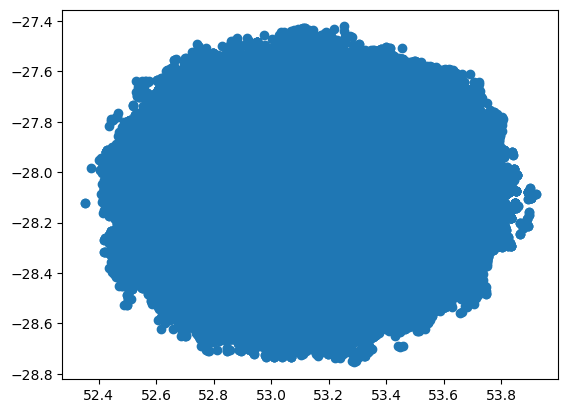

In [25]:
diaSource_50_single = diaSource_50[
    (diaSource_50['ra'] > 51) & 
    (diaSource_50['ra'] < 54) & 
    (diaSource_50['dec'] > -29) & 
    (diaSource_50['dec'] < -27)]
plt.scatter(diaSource_50_single['ra'], diaSource_50_single['dec'])

In [83]:
print(np.min(diaSource_50_single['midpointMjdTai']))
print(np.max(diaSource_50_single['midpointMjdTai']))
print(np.quantile(diaSource_50_single['midpointMjdTai'], [0.25,0.5, 0.75]))  

60623.258520653835
60655.24997618642
[60624.32376875 60644.26086312 60650.20091692]


60623.258520653835
60655.24997618642
[60632.08489634 60644.26086312 60646.08852494]


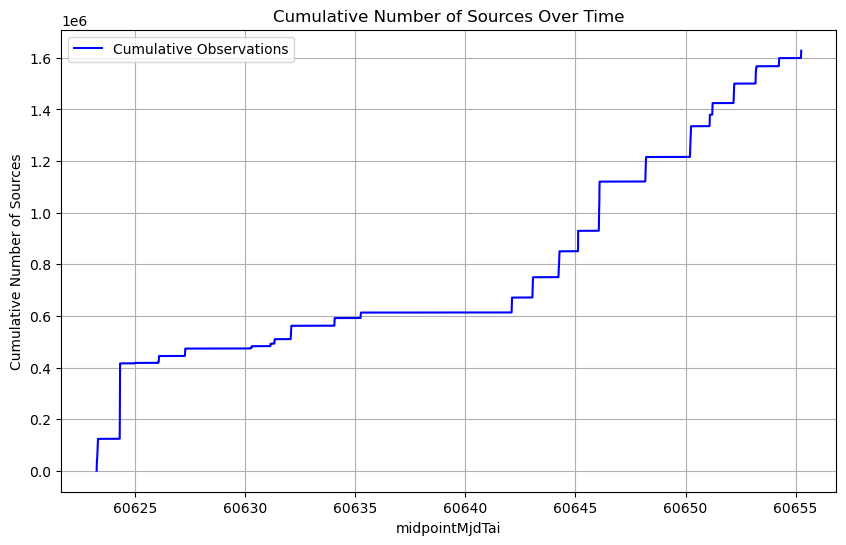

In [90]:
# Ensure 'midpointMjdTai' is sorted
diaSource_50_single_sorted = diaSource_50_single.sort_values(by='midpointMjdTai')

print(np.min(diaSource_50_single_sorted['midpointMjdTai']))
print(np.max(diaSource_50_single_sorted['midpointMjdTai']))
print(np.quantile(diaSource_50_single_sorted['midpointMjdTai'], [0.33,0.5, 0.66]))  

# Compute the cumulative count
cumulative_count = np.arange(1, len(diaSource_50_single_sorted) + 1)

# Plot cumulative number of observations vs. midpointMjdTai
plt.figure(figsize=(10, 6))
plt.plot(diaSource_50_single_sorted['midpointMjdTai'], cumulative_count, color='blue', label='Cumulative Observations')
# plt.plot(diaSource_50_single_sorted['visit'], cumulative_count, color='blue', label='Cumulative Observations')
plt.xlabel('midpointMjdTai')
plt.ylabel('Cumulative Number of Sources')
plt.title('Cumulative Number of Sources Over Time')
plt.grid(True)
plt.legend()
plt.show()

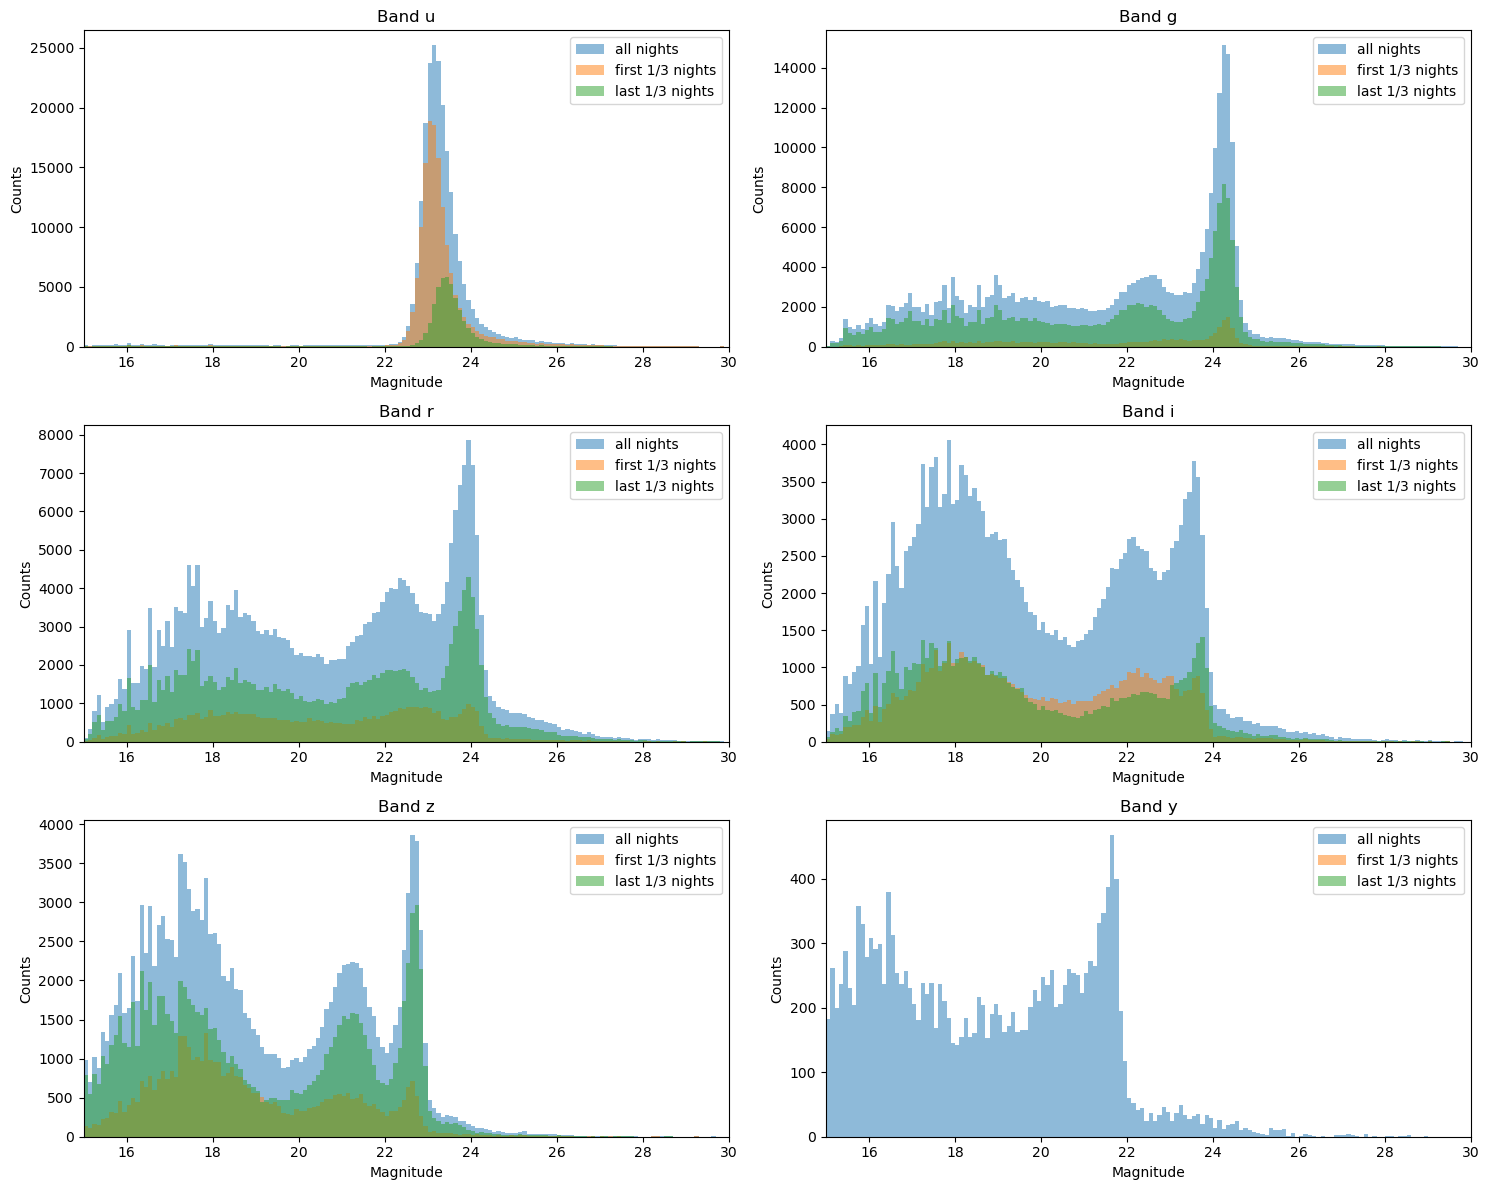

In [92]:
# Define the bands
bands = ['u', 'g', 'r', 'i', 'z', 'y']

# Create a figure with 6 subplots (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

# Loop over each band and create subplots
for idx, band in enumerate(bands):
    # Filter and process diaSource_50, diaSource_49, diaSource_48 for the current band
    dia_Source_single_band_50 = diaSource_50_single[diaSource_50_single['band'] == band].copy()
    dia_Source_single_band_50.loc[:, 'scienceMag'] = create_mag(dia_Source_single_band_50['scienceFlux'].values)
    dia_Source_single_band_50_early = dia_Source_single_band_50[dia_Source_single_band_50['midpointMjdTai']<60632]    
    dia_Source_single_band_50_late = dia_Source_single_band_50[dia_Source_single_band_50['midpointMjdTai']>60646]    
    # Plot histograms
    ax = axes[idx]
    ax.hist(dia_Source_single_band_50['scienceMag'], alpha=0.5, label='all nights', bins=np.arange(15, 30, 0.1))
    ax.hist(dia_Source_single_band_50_early['scienceMag'], alpha=0.5, label='first 1/3 nights', bins=np.arange(15, 30, 0.1))
    ax.hist(dia_Source_single_band_50_late['scienceMag'], alpha=0.5, label='last 1/3 nights', bins=np.arange(15, 30, 0.1))

    
    # Formatting
    ax.set_xlim(15, 30)
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Counts')
    ax.set_title(f'Band {band}')
    ax.legend()

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

# Positive and negative sources

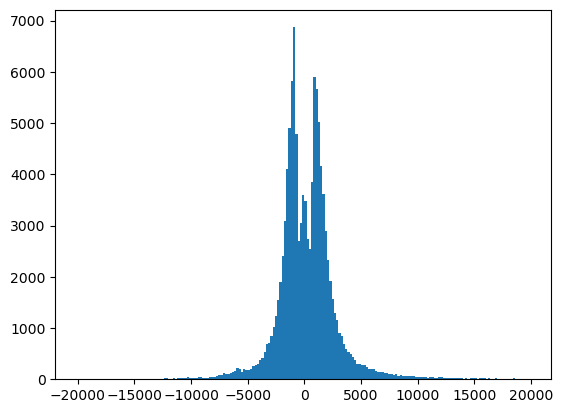

In [29]:
# Let us look at the flux distribution of the sources and see if it is reasonably symmetric
plt.hist(diaSource['psfFlux'],bins=np.arange(-20000,20000,200));

In [30]:
np.sum(diaSource[diaSource['psfFlux']<0]['shape_flag'])/len(diaSource[diaSource['psfFlux']<0]['shape_flag'])

0.7692573968809211

In [31]:
single_obj = dia_Obj[dia_Obj['nDiaSources'] > 10].iloc[230]
single_obj

ra                          3.979154e+01
dec                        -3.463544e+01
nDiaSources                 1.100000e+01
radecMjdTai                 6.063927e+04
r_psfFluxLinearSlope       -1.019732e+04
r_psfFluxLinearIntercept    6.183571e+08
r_psfFluxMAD                2.204495e+02
r_psfFluxMaxSlope           2.965827e+06
r_psfFluxErrMean            5.388733e+02
r_psfFluxMean              -8.868424e+02
r_psfFluxMeanErr            1.791592e+02
r_psfFluxNdata              9.000000e+00
r_scienceFluxMean           2.346104e+05
r_scienceFluxMeanErr        1.635344e+02
r_psfFluxMin               -1.745213e+03
r_psfFluxMax                9.897252e+02
r_psfFluxPercentile05      -1.736125e+03
r_psfFluxPercentile25      -1.092878e+03
r_psfFluxPercentile50      -8.724286e+02
r_psfFluxPercentile75      -8.021795e+02
r_psfFluxPercentile95       4.197547e+02
r_psfFluxSigma              8.070688e+02
r_scienceFluxSigma          5.946140e+03
r_psfFluxSkew               1.427427e+00
r_psfFluxChi2   

# MVW plot (i.e., shapes)

Text(0.5, 1.0, 'Shape Histogram of diaSources, g-band, ComCam')

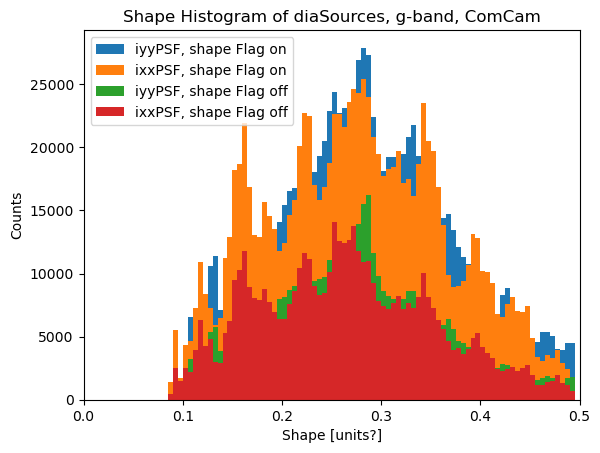

In [43]:
diaSource = diaSource_50

# Select a specific band, e.g., 'i'
selected_band = 'g'
src_subselection = diaSource.copy()

src_subselection = src_subselection[src_subselection['band'] == selected_band]
# Add 'diaSourceId' as a column
src_subselection['diaSourceId'] = src_subselection.index

# Filter for the selected band
# src_subselection = src_subselection[src_subselection['band'] == selected_band]

# Subset the relevant columns
src_subselection = src_subselection[['diaSourceId', 'ixx', 'iyy', 'ixy', 'ixxPSF', 'iyyPSF', 'ixyPSF', 'snr', 'shape_flag']]

src_subselection_shape_flag = src_subselection[src_subselection['shape_flag'] == 1]
src_subselection_no_shape_flag = src_subselection[src_subselection['shape_flag'] == 0]

plt.hist(src_subselection_shape_flag['iyyPSF'],  bins=np.arange(-0,0.5,0.005), label='iyyPSF, shape Flag on');
plt.hist(src_subselection_shape_flag['ixxPSF'],  bins=np.arange(-0,0.5,0.005), label='ixxPSF, shape Flag on');

plt.hist(src_subselection_no_shape_flag['iyyPSF'],  bins=np.arange(-0,0.5,0.005), label='iyyPSF, shape Flag off');
plt.hist(src_subselection_no_shape_flag['ixxPSF'],  bins=np.arange(-0,0.5,0.005), label='ixxPSF, shape Flag off');

plt.xlim(-0., 0.5)
plt.legend()
plt.xlabel('Shape [units?]')
plt.ylabel('Counts')
plt.title('Shape Histogram of diaSources, g-band, ComCam')

Text(0.5, 1.0, 'Shape Histogram of diaSources, g-band, ComCam')

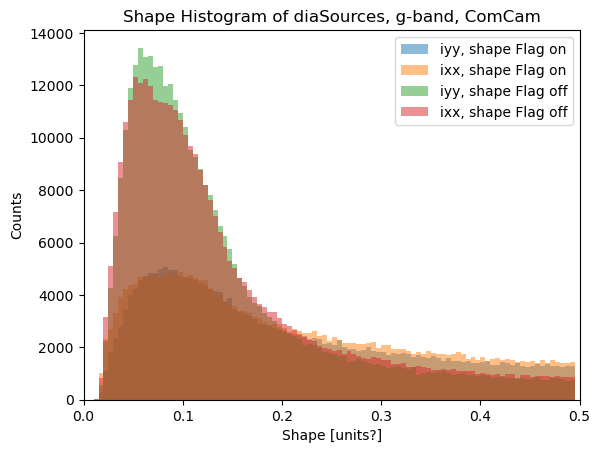

In [44]:
# Select a specific band, e.g., 'i'
selected_band = 'g'
src_subselection = diaSource.copy()

src_subselection = src_subselection[src_subselection['band'] == selected_band]
# Add 'diaSourceId' as a column
src_subselection['diaSourceId'] = src_subselection.index

# Filter for the selected band
# src_subselection = src_subselection[src_subselection['band'] == selected_band]

# Subset the relevant columns
src_subselection = src_subselection[['diaSourceId', 'ixx', 'iyy', 'ixy', 'ixxPSF', 'iyyPSF', 'ixyPSF', 'snr', 'shape_flag']]

src_subselection_shape_flag = src_subselection[src_subselection['shape_flag'] == 1]
src_subselection_no_shape_flag = src_subselection[src_subselection['shape_flag'] == 0]

plt.hist(src_subselection_shape_flag['iyy'],  bins=np.arange(-0,0.5,0.005), label='iyy, shape Flag on', alpha=0.5);
plt.hist(src_subselection_shape_flag['ixx'],  bins=np.arange(-0,0.5,0.005), label='ixx, shape Flag on', alpha=0.5);

plt.hist(src_subselection_no_shape_flag['iyy'],  bins=np.arange(-0,0.5,0.005), label='iyy, shape Flag off', alpha=0.5);
plt.hist(src_subselection_no_shape_flag['ixx'],  bins=np.arange(-0,0.5,0.005), label='ixx, shape Flag off', alpha=0.5);

plt.xlim(-0., 0.5)
plt.legend()
plt.xlabel('Shape [units?]')
plt.ylabel('Counts')
plt.title('Shape Histogram of diaSources, g-band, ComCam')

Text(0.5, 1.0, 'Shape Histogram of diaSources, g-band, ComCam')

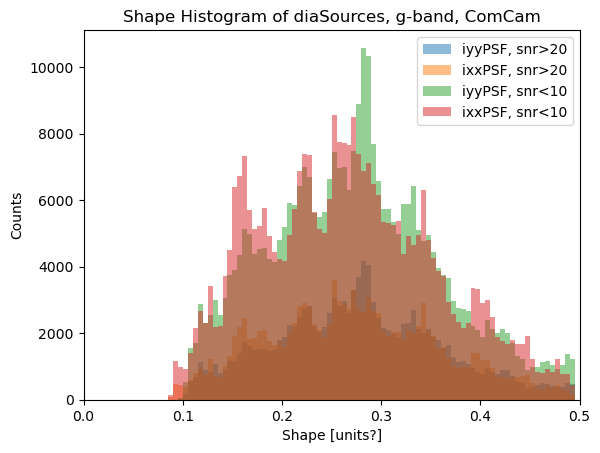

In [45]:
# Select a specific band, e.g., 'i'
selected_band = 'g'
src_subselection = diaSource.copy()

src_subselection = src_subselection[src_subselection['band'] == selected_band]
# Add 'diaSourceId' as a column
src_subselection['diaSourceId'] = src_subselection.index

# Filter for the selected band
# src_subselection = src_subselection[src_subselection['band'] == selected_band]

# Subset the relevant columns
src_subselection = src_subselection[['diaSourceId', 'ixx', 'iyy', 'ixy', 'ixxPSF', 'iyyPSF', 'ixyPSF', 'snr', 'shape_flag']]

src_subselection_shape_flag = src_subselection[src_subselection['snr'] >20]
src_subselection_no_shape_flag = src_subselection[src_subselection['snr'] >10]

plt.hist(src_subselection_shape_flag['iyyPSF'],  bins=np.arange(-0,0.5,0.005), label='iyyPSF, snr>20', alpha=0.5);
plt.hist(src_subselection_shape_flag['ixxPSF'],  bins=np.arange(-0,0.5,0.005), label='ixxPSF, snr>20', alpha=0.5);

plt.hist(src_subselection_no_shape_flag['iyyPSF'],  bins=np.arange(-0,0.5,0.005), label='iyyPSF, snr<10', alpha=0.5);
plt.hist(src_subselection_no_shape_flag['ixxPSF'],  bins=np.arange(-0,0.5,0.005), label='ixxPSF, snr<10', alpha=0.5);

plt.xlim(-0., 0.5)
plt.legend()
plt.xlabel('Shape [units?]')
plt.ylabel('Counts')
plt.title('Shape Histogram of diaSources, g-band, ComCam')

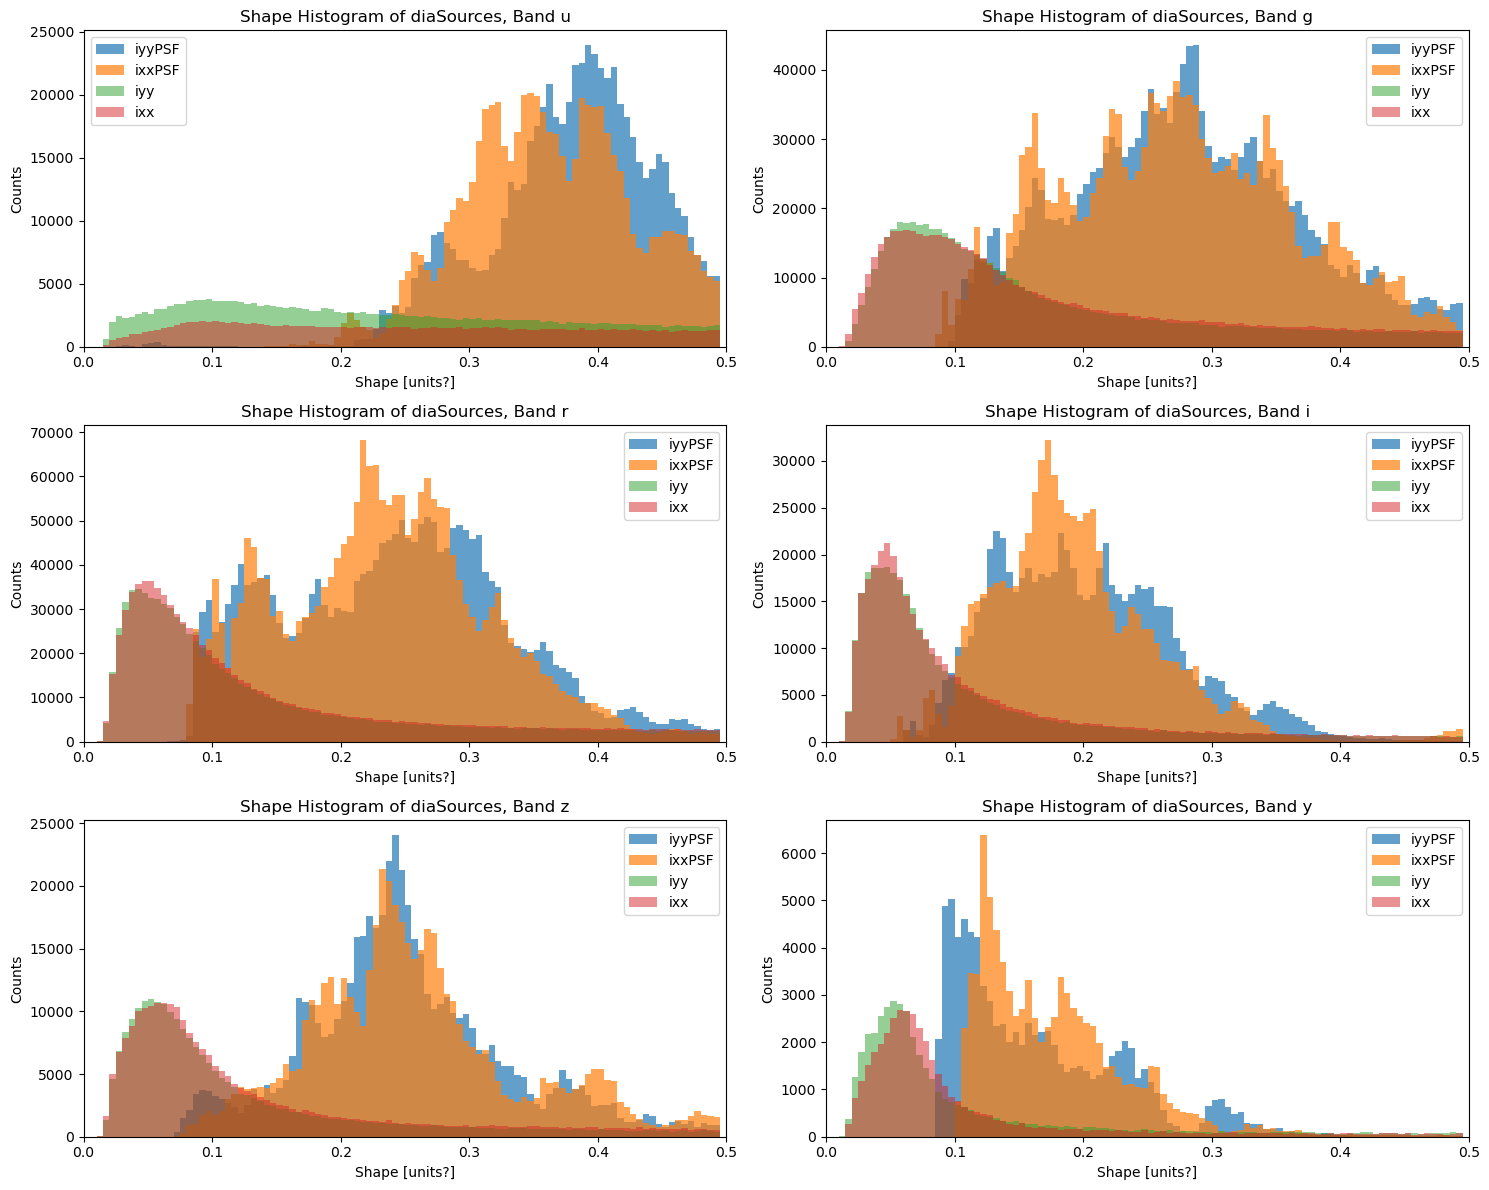

In [46]:

# Create a figure with 6 panels, one for each band
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, band in enumerate(bands):
    # Filter data for the current band
    src_subselection = diaSource[diaSource['band'] == band].copy()
    src_subselection['diaSourceId'] = src_subselection.index
    src_subselection = src_subselection[['diaSourceId', 'ixx', 'iyy', 'ixy', 'ixxPSF', 'iyyPSF', 'ixyPSF', 'snr', 'shape_flag']]
    
    # Plot histograms for the current band
    ax = axes[i]
    ax.hist(src_subselection['iyyPSF'], bins=np.arange(0, 0.5, 0.005), label='iyyPSF', alpha=0.7)
    ax.hist(src_subselection['ixxPSF'], bins=np.arange(0, 0.5, 0.005), label='ixxPSF', alpha=0.7)
    ax.hist(src_subselection['iyy'], bins=np.arange(0, 0.5, 0.005), label='iyy', alpha=0.5)
    ax.hist(src_subselection['ixx'], bins=np.arange(0, 0.5, 0.005), label='ixx', alpha=0.5)
    
    # Formatting
    ax.set_xlim(0, 0.5)
    ax.set_xlabel('Shape [units?]')
    ax.set_ylabel('Counts')
    ax.set_title(f'Shape Histogram of diaSources, Band {band}')
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

# MVW point about the shape flag

In [93]:
diaSource = diaSource_50

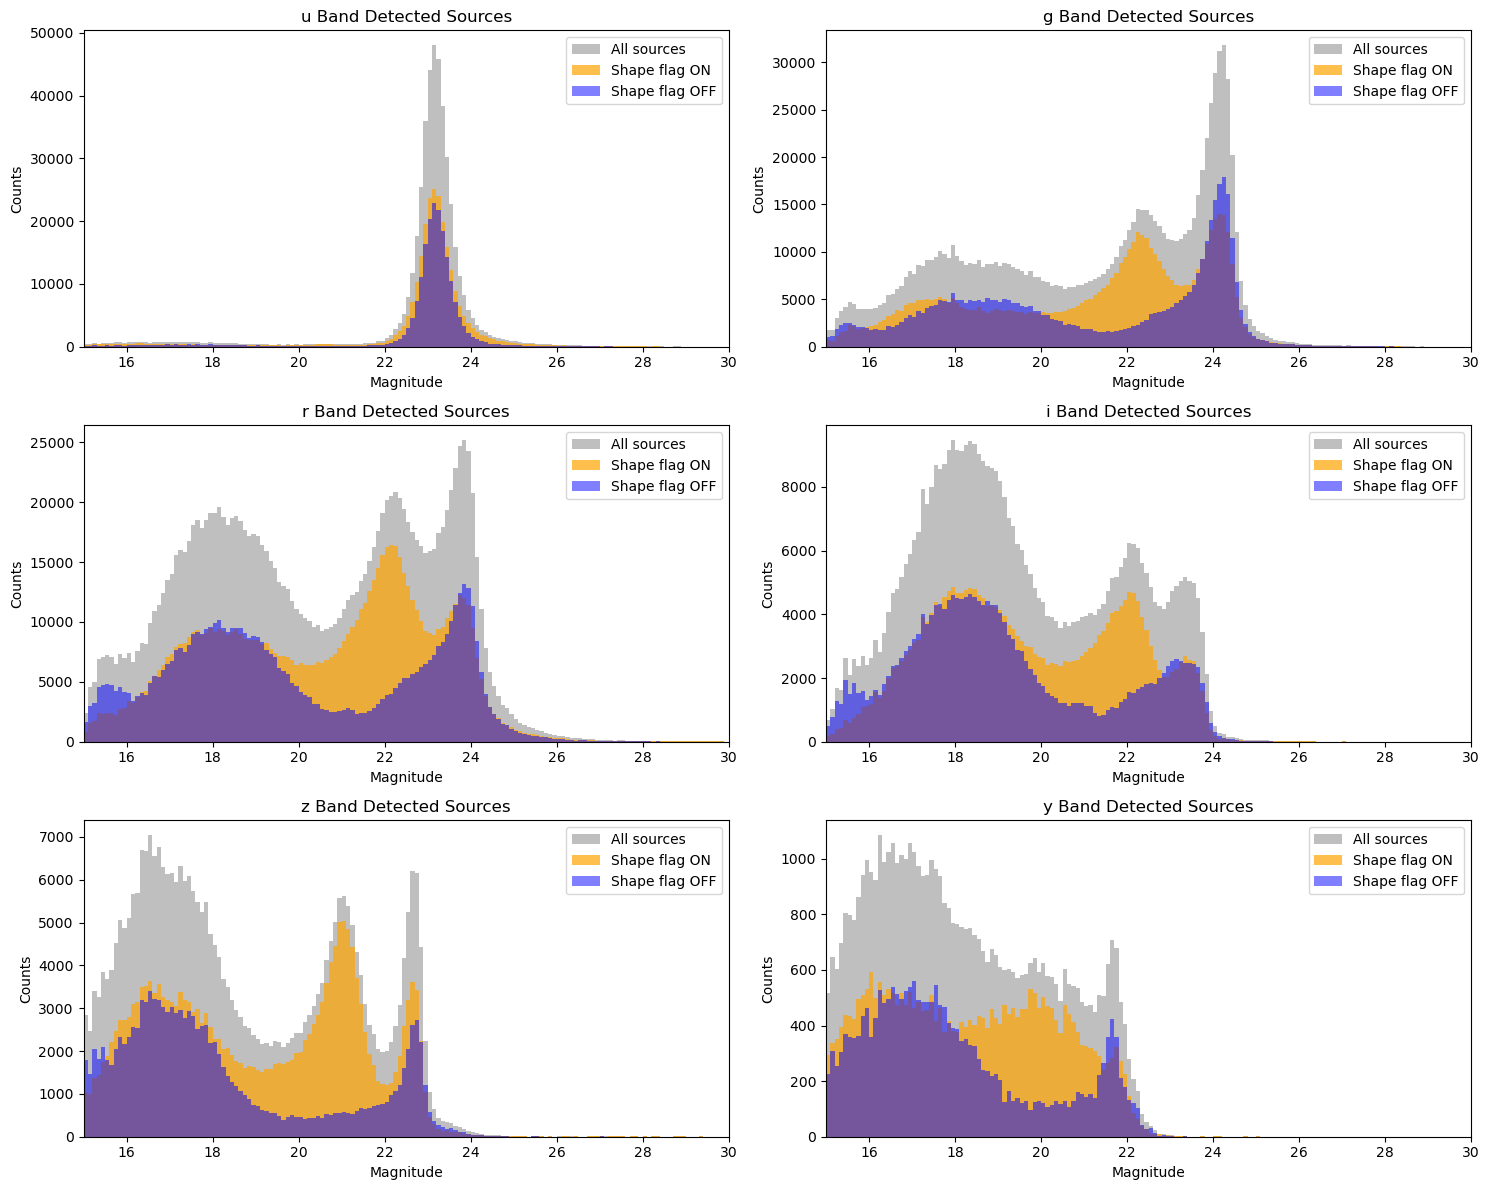

In [128]:

# List of bands to process
bands = ['u', 'g', 'r', 'i', 'z', 'y']

# Create a figure with 6 subplots (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

# Process each band and plot
for idx, band in enumerate(bands):
    # Select sources for the current band
    dia_Source_single_band = diaSource[diaSource['band'] == band]
    dia_Source_single_band_positive = dia_Source_single_band[dia_Source_single_band['psfFlux'] > 0].copy()
    dia_Source_single_band_positive.loc[:, 'scienceMag'] = create_mag(dia_Source_single_band_positive['scienceFlux'].values)
    
    # Split based on shape_flag
    dia_Source_single_band_positive_shapeflag_positive = dia_Source_single_band_positive[dia_Source_single_band_positive['shape_flag'] == 1]
    dia_Source_single_band_positive_shapeflag_negative = dia_Source_single_band_positive[dia_Source_single_band_positive['shape_flag'] == 0]
    
    # Plot histograms
    ax = axes[idx]
    ax.hist(dia_Source_single_band_positive['scienceMag'], color='gray', alpha=0.5, bins=np.arange(15, 30, 0.1), label='All sources')
    ax.hist(dia_Source_single_band_positive_shapeflag_positive['scienceMag'], color='orange', alpha=0.7, bins=np.arange(15, 30, 0.1), label='Shape flag ON')
    ax.hist(dia_Source_single_band_positive_shapeflag_negative['scienceMag'], color='blue', alpha=0.5, bins=np.arange(15, 30, 0.1), label='Shape flag OFF')
    
    # Formatting
    ax.set_xlim(15, 30)
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Counts')
    ax.set_title(f'{band} Band Detected Sources')
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [126]:
len(dia_Source_single_band_positive_shapeflag_positive)/len(dia_Source_single_band_positive)

0.5722153135548055

In [97]:
diaSource

,visit,detector,band,diaObjectId,ssObjectId,parentDiaSourceId,midpointMjdTai,bboxSize,time_processed,ra,...,shape_flag_parent_source,trail_flag_edge,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,coord_ra,coord_dec
diaSourceId,,,,,,,,,,,,,,,,,,,,,
191192032583090274,2024111700144,8,z,2132903024304062465,0,0,60632.084896,25,2024-12-15 15:08:41.382754,53.459654,...,False,False,False,False,False,False,False,False,53.459654,-28.688341
191860465834393604,2024120600079,2,g,2132907422350573590,0,0,60651.094458,18,2024-12-15 15:12:40.822793,53.340898,...,False,False,False,False,False,False,False,False,53.340904,-28.696781
191860465834393614,2024120600079,2,g,2132907422350573574,0,0,60651.094458,34,2024-12-15 15:12:40.822793,53.325028,...,False,False,False,False,False,False,False,False,53.325035,-28.698504
191860465834393630,2024120600079,2,g,2132907422350573571,0,0,60651.094458,22,2024-12-15 15:12:40.822793,53.278376,...,False,False,False,False,False,False,False,False,53.278367,-28.686731
191755008297926875,2024120300168,6,g,2132907422350573571,0,0,60648.202377,33,2024-12-15 15:14:31.357548,53.278384,...,False,False,False,False,False,False,False,False,53.278367,-28.686731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190769908139687991,2024110500226,2,r,2717130726746095752,0,0,60620.314776,16,2024-12-15 16:21:11.675330,59.915873,...,False,False,False,False,False,False,False,False,59.915873,-20.899323
190769897402269697,2024110500216,2,r,2717135124792606721,0,0,60620.308866,20,2024-12-15 15:33:24.806922,59.732686,...,False,False,False,False,False,False,False,False,59.732743,-20.905344
190769900623495169,2024110500219,2,r,2717135124792606721,0,0,60620.309489,18,2024-12-15 15:04:18.504459,59.732799,...,False,False,False,False,False,False,False,False,59.732743,-20.905344


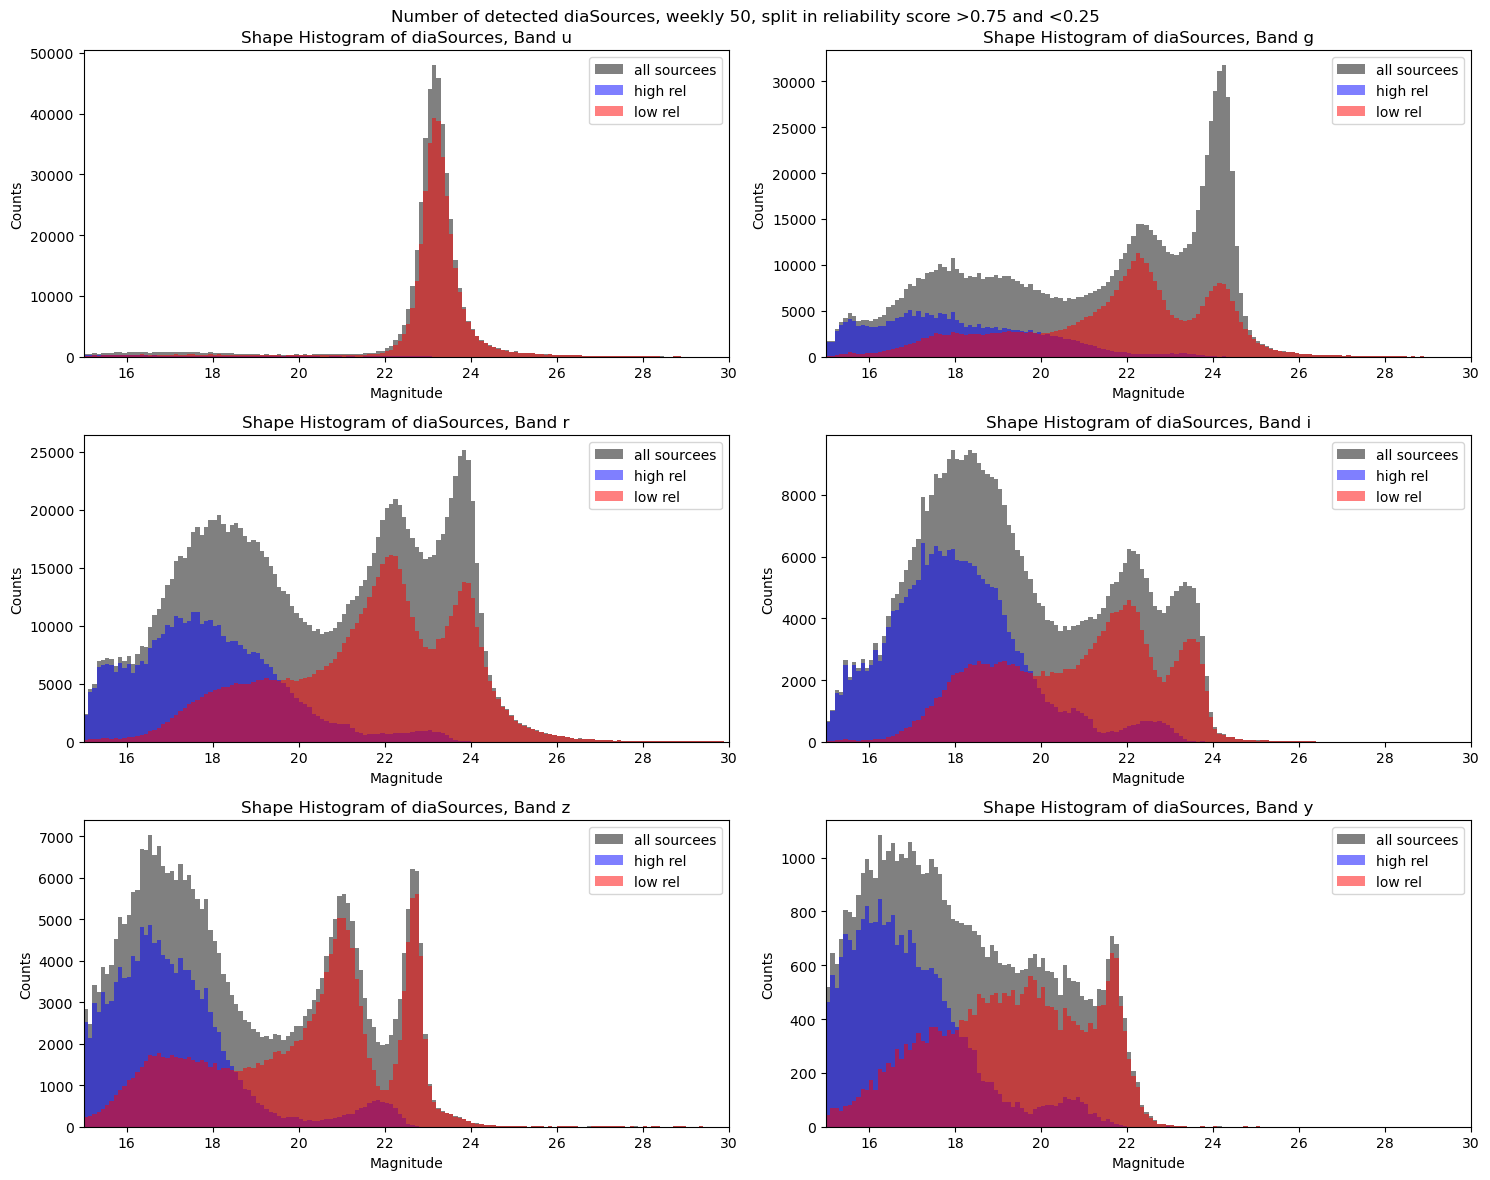

In [98]:
dia_Source_positive = diaSource[diaSource['psfFlux']>0].copy()
dia_Source_positive.loc[:, 'scienceMag'] = create_mag(dia_Source_positive['scienceFlux'].values)

# Create a figure with 6 panels, one for each band
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
plt.suptitle('Number of detected diaSources, weekly 50, split in reliability score >0.75 and <0.25')
axes = axes.flatten()

for i, band in enumerate(bands):
    # Filter data for the current band
    src_subselection = dia_Source_positive[dia_Source_positive['band'] == band].copy()
    src_subselection['diaSourceId'] = src_subselection.index
    dia_Source_single_band_positive_low_rel = src_subselection[src_subselection['reliability']<0.25]
    dia_Source_single_band_positive_high_rel = src_subselection[src_subselection['reliability']>0.75]
    
    # Plot histograms for the current band
    ax = axes[i]
    ax.hist(src_subselection['scienceMag'],  bins=np.arange(15,30,0.1), label='all sourcees', alpha=1, color='grey')
    ax.hist(dia_Source_single_band_positive_high_rel['scienceMag'], alpha=0.5, bins=np.arange(15,30,0.1), label='high rel', color='blue')
    ax.hist(dia_Source_single_band_positive_low_rel['scienceMag'], alpha=0.5, bins=np.arange(15,30,0.1), label='low rel', color='red')
    
    # Formatting
    ax.set_xlim(15, 30)
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Counts')
    ax.set_title(f'Shape Histogram of diaSources, Band {band}')
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

# Injected image

In [103]:
## Fakes run by Bruno Sanchez for ComCam
repo = "/repo/embargo_new"
collection = "u/bos/ComCam/APWithFakes/DM-47227/LSSTComCam_ApPipeWithFakes_v6"

butler_injections = dafButler.Butler(repo, collections=collection)

band = "i"
datasetRefs_dia = butler_injections.query_datasets("fakes_goodSeeingDiff_differenceExp", where=f"band='{band}'")

verbose = False
if verbose:
    for dr in datasetRefs_dia:
        print(dr)

print(f"\nFound {len(datasetRefs_dia)} differenceExps")

i = 40
data_id = datasetRefs_dia[i].dataId
print(data_id)


Found 45 differenceExps
{instrument: 'LSSTComCam', detector: 2, visit: 2024111700152, band: 'i', day_obs: 20241117, physical_filter: 'i_06'}


In [104]:
def good_sources(dia_src, dia_src_table, verbose=True):
    """
    Filter "good" DIA (Difference Image Analysis) sources based on signal-to-noise ratio (SNR) 
    and quality flags.

    Parameters
    ----------
    dia_src : pandas.DataFrame
        Optional auxiliary DIA source table (handles 'sky_source' if present).
    dia_src_table : pandas.DataFrame
        Main DIA source table with columns for SNR, shape, and pixel quality flags.
    verbose : bool, optional
        Print the number of good sources found (default: True).

    Returns
    -------
    pandas.DataFrame
        Filtered table of good DIA sources.
    """
    
    try:
        dia_src = dia_src[~dia_src["sky_source"]]
    except:
        pass
    
    # If I were doing just dia_src_table, I'd do something like this:
    just_dia_src_table = True
    if just_dia_src_table:
        good = (dia_src_table["snr"] > snr_threshold) & \
            ~dia_src_table["shape_flag"] & \
            ~dia_src_table["pixelFlags_bad"] & \
            ~dia_src_table["pixelFlags_cr"] & \
            ((dia_src_table["scienceFlux"] / dia_src_table["scienceFluxErr"]) < max_science_snr)
    else:
        good = ~dia_src["slot_Shape_flag"] & \
            (dia_src["base_PsfFlux_instFlux"] / dia_src["base_PsfFlux_instFluxErr"] > snr_threshold) & \
            ~dia_src["base_PixelFlags_flag_edge"] & \
            ((dia_src_table["scienceFlux"] / dia_src_table["scienceFluxErr"]) < max_science_snr) & \
            ~dia_src_table["pixelFlags_streak"]
    
    good_dia_src = dia_src_table[good].copy(deep=True)
    
    print(f"{len(good_dia_src)} good DIA sources found out of {len(dia_src)} detections.")
    
    return good_dia_src

In [124]:
snr_threshold = 5
max_science_snr = 300

dia = butler_injections.get("goodSeeingDiff_differenceExp", dataId=data_id)
template = butler_injections.get("goodSeeingDiff_templateExp", dataId=data_id)
calexp = butler_injections.get("calexp", dataId=data_id)
src = butler_injections.get("src", dataId=data_id)
dia_src = butler_injections.get("goodSeeingDiff_diaSrc", dataId=data_id)
dia_src_table = butler_injections.get("goodSeeingDiff_diaSrcTable", dataId=data_id)  # SDM-ified table.  Does not containg sky sources

injected_dia = butler_injections.get("fakes_goodSeeingDiff_differenceExp", dataId=data_id)
injected_template = butler_injections.get("fakes_goodSeeingDiff_templateExp", dataId=data_id)
injected_calexp = butler_injections.get("fakes_initial_pvi", dataId=data_id)
injected_dia_src = butler_injections.get("fakes_goodSeeingDiff_diaSrc", dataId=data_id)
injected_dia_src_table = butler_injections.get("fakes_goodSeeingDiff_diaSrcTable", dataId=data_id)  # SDM-ified table.  Does not containg sky sources
# Pre-matched tables
injected_match_dia_src_table = butler_injections.get("fakes_goodSeeingDiff_matchDiaSourceTable", dataId=data_id)
injected_match_dia_src = butler_injections.get("fakes_goodSeeingDiff_matchDiaSrc", dataId=data_id)

# This is the catalog of the injected fakes in RA, Dec
injected_fakes = butler_injections.get("fakes_initial_pvi_catalog", dataId=data_id)

In [109]:
good_dia_src = good_sources(dia_src, dia_src_table)

17 good DIA sources found out of 144 detections.


In [118]:
# these are all the sources that have passed the cuts, before any injections
good_dia_src = dia_src_table[(dia_src_table['shape_flag']==False) &  ((dia_src_table["scienceFlux"] / dia_src_table["scienceFluxErr"]) < max_science_snr)]
# these are all of the sources that have passed the cuts, after the injections
# 20 have been injected and found 
good_injected_dia_src = good_sources(injected_dia_src, injected_dia_src_table)

29 good DIA sources found out of 169 detections.


In [122]:
injected_dia_src_table[injected_dia_src_table['pixelFlags_injected']==True]

,diaSourceId,visit,detector,band,diaObjectId,ssObjectId,parentDiaSourceId,midpointMjdTai,bboxSize,time_processed,...,shape_flag_no_pixels,shape_flag_not_contained,shape_flag_parent_source,trail_flag_edge,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter
18,191192041147858964,2024111700152,2,i,0,0,0,60632.093929,32,2024-11-25 21:08:56.732032,...,False,False,False,False,False,False,True,True,False,False
20,191192041147858966,2024111700152,2,i,0,0,0,60632.093929,23,2024-11-25 21:08:56.732032,...,False,False,False,False,False,False,True,True,False,False
22,191192041147858968,2024111700152,2,i,0,0,0,60632.093929,34,2024-11-25 21:08:56.732032,...,False,False,False,False,False,False,True,True,False,False
27,191192041147858973,2024111700152,2,i,0,0,0,60632.093929,23,2024-11-25 21:08:56.732032,...,False,False,False,False,False,False,True,True,False,False
35,191192041147858981,2024111700152,2,i,0,0,0,60632.093929,26,2024-11-25 21:08:56.732032,...,False,False,False,False,False,False,True,True,False,False
52,191192041147858998,2024111700152,2,i,0,0,0,60632.093929,22,2024-11-25 21:08:56.732032,...,False,False,False,False,False,False,True,True,False,False
53,191192041147858999,2024111700152,2,i,0,0,0,60632.093929,22,2024-11-25 21:08:56.732032,...,False,False,False,False,False,False,True,True,False,False
57,191192041147859003,2024111700152,2,i,0,0,0,60632.093929,23,2024-11-25 21:08:56.732032,...,False,False,False,False,False,False,True,True,False,False
69,191192041147859015,2024111700152,2,i,0,0,0,60632.093929,30,2024-11-25 21:08:56.732032,...,False,False,False,False,False,False,True,True,False,False
70,191192041147859016,2024111700152,2,i,0,0,0,60632.093929,27,2024-11-25 21:08:56.732032,...,False,False,False,False,False,False,True,True,False,False
